<a href="https://colab.research.google.com/github/mz-zarei/TimeSeriesAnalysis/blob/main/PedestrianFlowForecasting/PedCrossVolumeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports

In [1]:
# Create a virtual environment and install all requirements
# Got to the project folder and use following command in the terminal:
#   python3 -m venv .venv
#   source .venv/bin/activate
#   pip install -r ../requirements.txt

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ignore warnings
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline

# 1. Read Data

In [14]:
from utils import load_transform

path_to_data = '../data/milton.csv'
data = load_transform(path_to_data, 
                    start_date = "2021-10-01", 
                    end_date = "2022-09-30", 
                    drop = True, 
                    verbos = False
                    )

# 3. EDA

       vol_vehicle  ped_N  ped_S  ped_E  ped_W
count        362.0  362.0  362.0  362.0  362.0
mean      20,926.5   62.2   18.4   55.7   47.0
std        3,614.8   26.7    8.9   32.5   44.2
min        7,771.0    2.0    2.0   14.0    3.0
25%       18,861.5   43.0   12.0   39.2   28.0
50%       21,060.0   61.5   17.0   54.0   37.0
75%       23,065.5   80.0   24.0   69.0   52.0
max       28,771.0  195.0   55.0  541.0  596.0


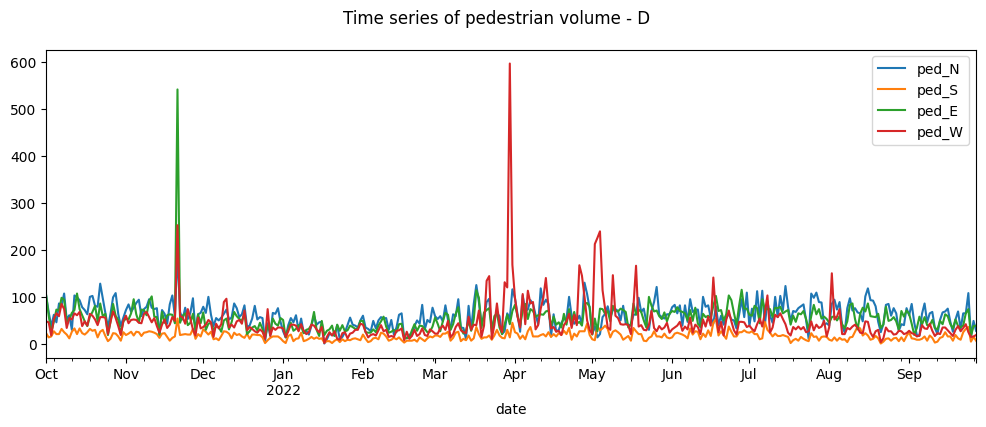

In [15]:
from utils import plot_ts

intersection_name = 'Ontario Street South and Pine Street'
# take the data for the given intersection
df_int = data.loc[data['name'] == intersection_name, :]

plot_ts(df_int, 
        agg_level = 'D', 
        show_stat=True
        )

# 4. Compute 24h pedestrian volume


 Ontario Street South and Pine Street
# of flagged rows with F1 (missing): 25
# of flagged rows with F2 (more than H15): 1
# of flagged rows with F3 (less than T24): 0
# of flagged rows with F4 (more than H24): 2
# of valid 24h volumes:  360


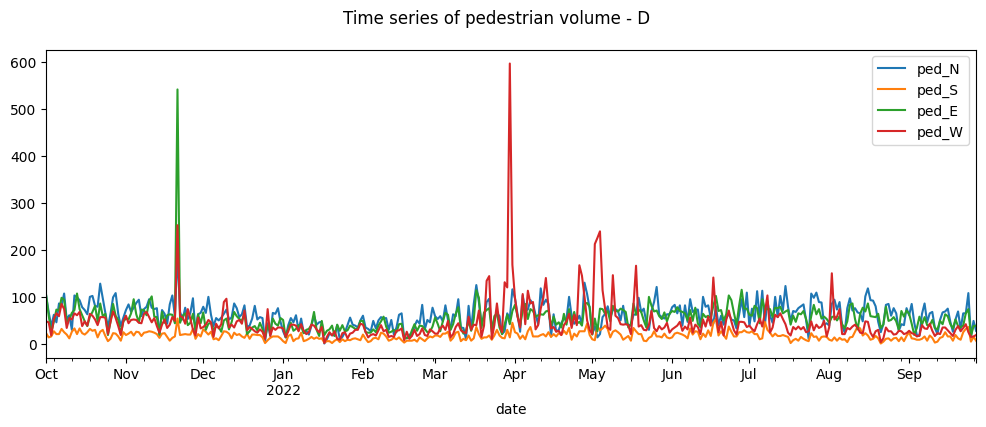

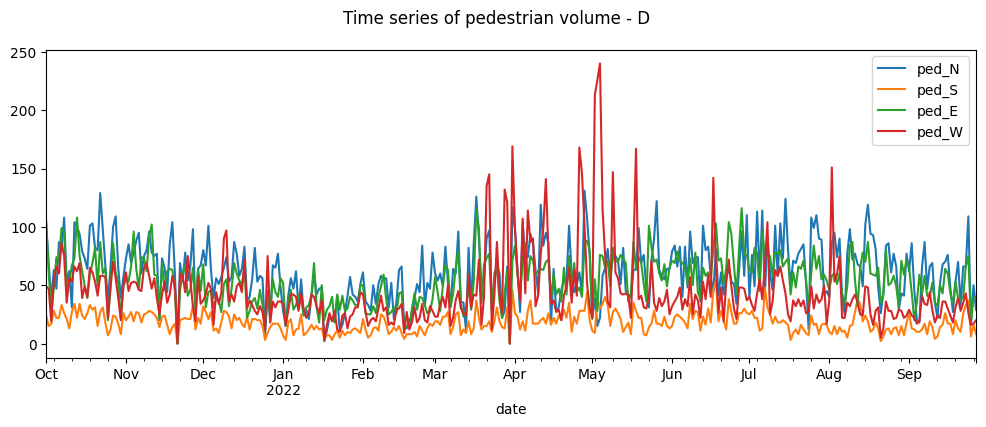

In [16]:
from utils import get_24h_count_df

df_int_24h = get_24h_count_df(data, intersection_name, H15=100, H24=500, T24=72, verbos=True) 
print('# of valid 24h volumes: ', len(df_int_24h))

# Plotting the time series of Ped counts for each crossing
plot_ts(df_int, show_stat=False)
plot_ts(df_int_24h, show_stat=False)

# 5. Compute true volume ratio for each approach

In [17]:
from utils import get_true_ratio
AADPT, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true = get_true_ratio(df_int_24h)

print(f'AADPT: {AADPT}')
print(f'True Ratios N:{ratio_N_true:.{2}f}, S:{ratio_S_true:.{2}f}')
print(f'           W:{ratio_W_true:.{2}f}, E:{ratio_E_true:.{2}f}')

AADPT: 178.52857142857144
True Ratios N:0.35, S:0.10
           W:0.25, E:0.30


# 6. Calculate short-term counts for each approach

In [19]:
from utils import get_8h_count_df

holidays = pd.read_csv('../data/milton_holidays.csv').values.reshape(-1)

df_int_8h = get_8h_count_df(data,
                            intersection_name,
                            holidays, 
                            verbos=True)
df_int_8h

valid STC: 75, droped zero counts: 0
Hours:  Int64Index([7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18], dtype='int64', name='date')
Day of Weeks:  Int64Index([1, 2, 3], dtype='int64', name='date')
Months:  Int64Index([10, 11, 4, 5, 6, 9], dtype='int64', name='date')


,vol_vehicle,ped_N,ped_S,ped_E,ped_W,total
date,,,,,,
2021-10-05,19171,35,20,46,46,147
2021-10-06,18737,68,15,51,42,176
2021-10-07,20076,65,25,80,74,244
2021-10-12,19720,85,30,59,57,231
2021-10-13,19968,85,17,85,52,239
...,...,...,...,...,...,...
2022-09-15,17293,66,21,53,30,170
2022-09-20,16067,61,12,33,31,137
2022-09-21,16371,30,8,35,25,98


# 7. Calculate volume ratio error from ST counts

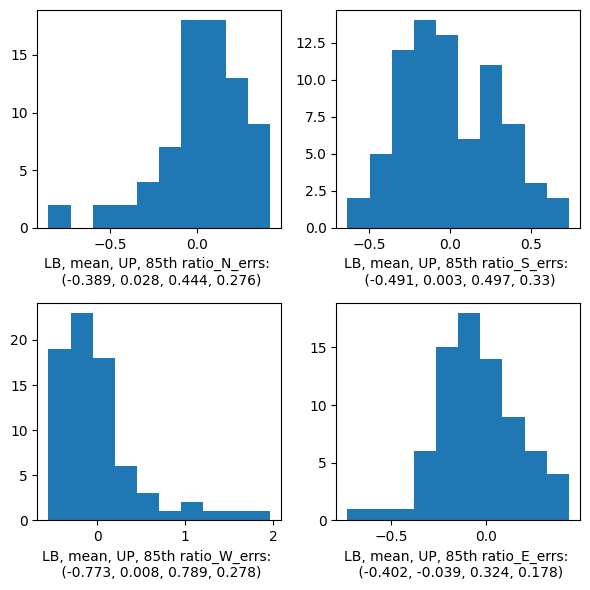

Text(0.5, 1.0, 'LB, mean, UP, 85th for AVG errors: \n (-0.075, 0.22, 0.515, 0.32)')

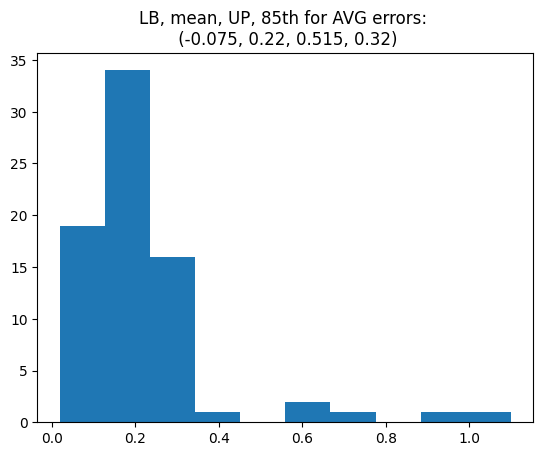

In [20]:
from utils import get_ratio_errors, get_confidence_interval

error_df = get_ratio_errors(df_int_8h, 
                            df_int_24h,
                            stc_num = 1,
                            repeat = 100)

# Plot the dist of the errors and 95% CI
fig, axes = plt.subplots(2,2, figsize=(6,6))
for ax, col in [(axes[0,0], 'ratio_N_errs'),(axes[0,1],'ratio_S_errs'),
                (axes[1,0], 'ratio_W_errs'),(axes[1,1],'ratio_E_errs')]:
    ax.hist(error_df[col].values, bins=10)
    ax.set_xlabel(f'LB, mean, UP, 85th {col}: \n {get_confidence_interval(error_df[col].values)}')

plt.tight_layout()
plt.show()

plt.hist(error_df['ratio_avg_errs'].values, bins=10) 
plt.title(f'LB, mean, UP, 85th for AVG errors: \n {get_confidence_interval(error_df["ratio_avg_errs"].values)}')   

# Perform analysis on all intersections

In [ ]:
! python main.py --dataset "milton" --stc-num 3 --repeat 100 --percentile 85 --verbos False

In [24]:
error_df = pd.read_csv("./outs/milton_error_df.csv")
error_df

,ratio_N_errs,ratio_S_errs,ratio_W_errs,ratio_E_errs,ratio_avg_errs,intersection
0,-0.0,0.1,0.1,-0.1,0.1,Thompson Road and Laurier Avenue
1,-0.1,-0.1,0.1,0.0,0.1,Thompson Road and Laurier Avenue
2,-0.1,-0.1,0.1,0.0,0.1,Thompson Road and Laurier Avenue
3,0.0,-0.0,0.0,-0.0,0.0,Thompson Road and Laurier Avenue
4,0.1,-0.0,-0.1,0.1,0.1,Thompson Road and Laurier Avenue
...,...,...,...,...,...,...
1295,-0.2,0.1,0.0,-0.1,0.1,Main Street West and Scott Boulevard
1296,-0.2,0.1,0.0,-0.1,0.1,Main Street West and Scott Boulevard
1297,-0.0,0.0,0.0,-0.0,0.0,Main Street West and Scott Boulevard
1298,-0.2,0.1,-0.1,0.0,0.1,Main Street West and Scott Boulevard


In [25]:
res_df = pd.read_csv("./outs/milton_res_df.csv")
res_df

,intersection,valid_24h_counts,AADPT,ratio_N_true,ratio_S_true,ratio_W_true,ratio_E_true,valid_8h_stc,LB_avg_err,MEAN_avg_err,...,UB_S_err,PTILE_S_err,LB_W_err,MEAN_W_err,UB_W_err,PTILE_W_err,LB_E_err,MEAN_E_err,UB_E_err,PTILE_E_err
0,Thompson Road and Laurier Avenue,362,267.2,0.2,0.1,0.4,0.3,75,0.0,0.1,...,0.1,0.1,-0.1,-0.0,0.1,0.1,-0.1,0.0,0.2,0.1
1,Ontario Street South and Childs Drive,362,130.3,0.2,0.1,0.3,0.5,75,-0.0,0.2,...,0.4,0.2,-0.5,0.1,0.7,0.5,-0.3,-0.0,0.2,0.1
2,Ontario Street South and Pine Street,360,178.5,0.3,0.1,0.2,0.3,75,0.0,0.2,...,0.3,0.1,-0.5,0.1,0.6,0.4,-0.3,-0.0,0.2,0.1
3,Main Street East and Ontario Street North,361,302.3,0.4,0.1,0.2,0.3,75,0.0,0.2,...,0.8,0.5,-0.1,0.0,0.2,0.1,-0.1,0.0,0.1,0.1
4,Bronte Street North and Main Street West,361,203.7,0.1,0.5,0.1,0.3,75,0.0,0.2,...,0.2,0.1,-0.6,0.2,1.1,0.7,-0.2,-0.0,0.1,0.0
5,Laurier Avenue and Ontario Street South,362,294.1,0.3,0.3,0.2,0.2,75,0.0,0.1,...,0.3,0.2,-0.3,-0.2,-0.0,-0.1,-0.3,-0.1,0.0,-0.0
6,Thompson Road and Drew Centre,361,604.2,0.1,0.3,0.3,0.3,75,0.0,0.1,...,0.1,0.1,-0.2,-0.1,0.0,-0.0,-0.0,0.0,0.1,0.1
7,Louis St Laurent Avenue and Farmstead Drive,362,452.3,0.2,0.3,0.3,0.2,75,0.1,0.1,...,0.1,0.1,0.0,0.2,0.3,0.3,-0.2,-0.1,0.0,-0.0
8,Main Street E and Harris / Pearson,362,584.6,0.2,0.3,0.3,0.3,75,0.2,0.2,...,-0.1,-0.1,0.1,0.2,0.3,0.3,0.1,0.2,0.3,0.3
9,Main Street East and Maple / Sinclair,362,229.3,0.3,0.3,0.2,0.2,75,0.0,0.1,...,0.2,0.1,-0.1,0.1,0.2,0.2,-0.2,-0.1,0.1,0.0
